# Censored Regressors with Pyro GP Module: 1D test functions, Gaussian derived likelihoods and RBF kernel

This notebook provides a basic toolbox for the Gaussian processess framework implementation in pyro.contrib.gp module for censored regressor problem

In [204]:
!pip install -q pyro-ppl

In [205]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

import tqdm

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

In [206]:
import numpy as np
import matplotlib.pyplot as plt

# Data Generation

## 1. 1-D Test Functions

We generate the different 1-D data points from a various test functions.
The test function is specifed in the dictionary and the parameters to specify are:
 * `start`: the lower bound of the interval from which we sample the x-axis grid   
 * `end`: the upper bound of the interval from which we sample the x-axis grid
 * `num_of_points`: num of equidistant points to cover the x-axis grid
 * `num_of_points_tes`: num of equdistant points for the x-axis grid in which we evaluate the predicted function
 * `padding`: length of the intraval added to lower and upper bound to extend the train x-axis grid, its used for testing and measuring the ability of the model to extrapolate outside the training regions  

In [207]:
# define function in the torch specific way
fcn1 = lambda x: 0.5 * torch.sin(3 * x)
fcn2 = lambda x: torch.pow((6 * x - 2),2)* torch.sin(2 * (6 * x - 2))
fcn3 = lambda x: torch.Tensor(x) * torch.sin(x)

fcn_dict = {
    # label, [start, end, num_of_points, num_of_points_test, padding for test region ], fcn
    'fcn1': ["$f(x) = 0.5 \sin(3x)$", [0, 5, 20, 500, 0.5], fcn1],
    'fcn2': ["$f(x) = (6x - 2)^2 \sin[2(6x - 2)]$", [0, 1, 30, 500, 0.5], fcn2],
    'fcn3': ["$f(x) = x \sin(x)$", [0, 10, 1000, 500, 0.5], fcn3]
    }

In [208]:
# set hyperparameters for data generation

fcn_key_ = 'fcn3' # select function
noise_std = 0.2 # dd noise
N = 30 # number of training data points

# set perscentile corresponding to the treshold --> values smaller than given treshold are assigned treshold value
treshold = 40

__Generated variables__

*   variable X is x-axis grid over which the values of the function f(x) are being computed  
*   variable y correspond to f(x) values
* (X_train, y_train) is uniformly subsampled N points used for training
* (X_train, y_train_noise) is uniformly subsampled N points used for training with mixed in Gaussian noise with variance specified in variable noise_std
* X_test is x-grid which has extra padding on both side outside the train interval to test the ability of the model to extrapolate
* (X_test, y_test) fucntion f(x) computed on the testing interval X_test

In [209]:
# generate data
# get grid
X = np.linspace(
    start=fcn_dict[fcn_key_][1][0],
    stop=fcn_dict[fcn_key_][1][1],
    num=fcn_dict[fcn_key_][1][2]).reshape(-1, 1)

# apply selected function
temp_y = fcn_dict[fcn_key_][2](torch.Tensor(X))
y = np.squeeze(temp_y.numpy())

# sample training set
X_train = dist.Uniform(fcn_dict[fcn_key_][1][0], fcn_dict[fcn_key_][1][1]).sample(sample_shape=(N,))
y_train = fcn_dict[fcn_key_][2](torch.Tensor(X_train))
# mix in normal noise
y_train_noisy = y_train + dist.Normal(0.0, noise_std).sample(sample_shape=(N,))

X_test = np.squeeze(np.linspace(
    start=fcn_dict[fcn_key_][1][0] - fcn_dict[fcn_key_][1][4],
    stop=fcn_dict[fcn_key_][1][1] + fcn_dict[fcn_key_][1][4],
    num=fcn_dict[fcn_key_][1][3]))

temp_y_test = fcn_dict[fcn_key_][2](torch.Tensor(X_test))
y_test = np.squeeze(temp_y_test.numpy())

__Censoring__
* compute bound for a given percentile and replaces all values smaller than the bound with the bound value
* `censoring_id` is an identifier indicating positions of the values on which the censoring was applied  

In [210]:
# apply censoring
lower_cf = np.percentile(y_train, treshold)
print(lower_cf)
y_train_censored = np.clip(y_train, lower_cf, None)
y_train_noisy_censored = np.clip(y_train_noisy, lower_cf, None)
censoring_id = np.zeros(len(y_train))

-0.7463307058068248


In [211]:
y_train

tensor([-2.6412,  5.0529, -4.5616,  1.9851,  1.0725,  7.8984,  1.7448, -1.2680,
        -2.6317,  0.7389, -4.4525,  1.7337, -1.4196, -0.3986, -4.7914, -4.2054,
        -3.2678,  1.8188,  2.3875,  7.8486,  1.8120,  3.1503,  0.9766, -4.5318,
         1.7440, -3.5995, -2.3306,  3.4843,  6.8647,  1.7327])

In [212]:
y_train_censored

tensor([-0.7463,  5.0529, -0.7463,  1.9851,  1.0725,  7.8984,  1.7448, -0.7463,
        -0.7463,  0.7389, -0.7463,  1.7337, -0.7463, -0.3986, -0.7463, -0.7463,
        -0.7463,  1.8188,  2.3875,  7.8486,  1.8120,  3.1503,  0.9766, -0.7463,
         1.7440, -0.7463, -0.7463,  3.4843,  6.8647,  1.7327])

In [213]:
censoring_id

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

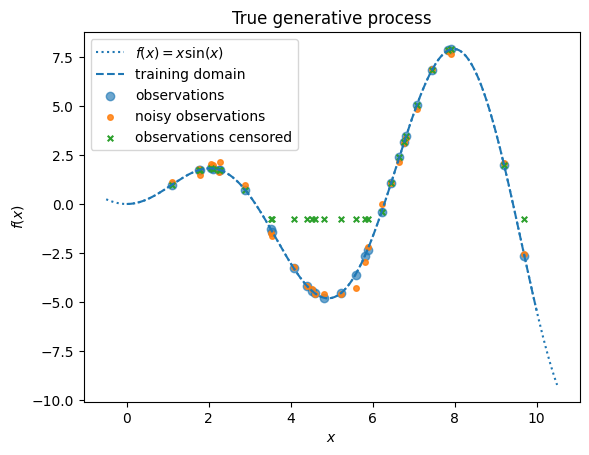

In [214]:
plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
plt.plot(X, y, label='training domain', linestyle="dashed", color=sns.color_palette()[0])
plt.scatter(X_train, y_train, label="observations",  alpha=0.65, color=sns.color_palette()[0])
plt.scatter(X_train, y_train_noisy, label="noisy observations", s=16, alpha=0.85, color=sns.color_palette()[1])
plt.scatter(X_train, y_train_censored, label="observations censored", s=16, color=sns.color_palette()[2], marker='x')

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

# Experiments

In [215]:
def is_var(model):
  if type(model) == gp.models.VariationalSparseGP or type(model) == gp.models.VariationalGP:
    res = True
  else:
    res = False
  return res

def optimise(model, num_steps = 2000, lr_=0.005, MeanFieldElbo=False):
  pyro.clear_param_store()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_)
  if MeanFieldElbo==True:
      loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
  else:
      loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

  losses = []
  variances = []
  lengthscales = []
  noises = []

  pbar = tqdm.tqdm(range(num_steps), position=0, leave=True)

  for epoch in pbar:
      variances.append(model.kernel.variance.item())
      lengthscales.append(model.kernel.lengthscale.item())
      if is_var(model)==True:
        noises.append(model.likelihood.variance.item())
      else:
        noises.append(model.noise.item())

      optimizer.zero_grad()
      loss = loss_fn(model.model, model.guide)
      loss.backward()
      optimizer.step()

      losses.append(loss.item())

  model.set_mode("guide")
  print("\nvariance = {: .6f}".format(model.kernel.variance))
  print("lengthscale = {: .6f}".format(model.kernel.lengthscale))
  if is_var(model)==True:
    print("noise = {: .6f}".format(model.likelihood.variance))
  else:
    print("noise = {: .6f}".format(model.noise))
  res = {'model': model,
          'losses' : losses,
          'variances' : variances,
          'lengthscales' : lengthscales,
          'noises' : noises}
  return res

In [216]:
def visualise_training(losses, variances, lengthscales, noises):
  fig, ax = plt.subplots(1, 4, figsize=(15, 3))
  ax[0].plot(losses)
  ax[0].set_title('loss')
  ax[1].plot(variances)
  ax[1].set_title('variance')
  ax[2].plot(lengthscales)
  ax[2].set_title('lengthscales')
  ax[3].plot(noises)
  ax[3].set_title('noise parameter')

def mse(predicted, labels):
    res = torch.mean((predicted - labels) ** 2)
    return res

def rmse(predicted, labels):
    res = torch.sqrt(mse(predicted, labels))
    return res

def visualise_results(model, grid=X_train, labels=y_train, censored=None, title_=' '):
  with torch.no_grad():
    mean, cov = model.forward(torch.Tensor(X_test), full_cov=True)
    mean_train, cov_train = model.forward(torch.Tensor(X_train), full_cov=True)
  sd = cov.diag().sqrt().numpy()
  rmse_train = rmse(mean_train, torch.Tensor(y_train)).numpy()
  rmse_test = rmse(mean, torch.Tensor(y_test)).numpy()

  title_ = '{}\nrmse train: {: .4f}, rmse test: {: .4f}'.format(title_, rmse_train, rmse_test)
  plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
  plt.scatter(X_train, y_train, label="Observations")
  plt.plot(X_test, mean.numpy(), label="Mean prediction")
  if censored is not None:
    plt.scatter(X_train, censored, label="noisy observations", s=16, alpha=0.85, color=sns.color_palette()[2], marker='x')
  plt.fill_between(
      X_test.ravel(),
      mean.numpy() - 1.96 * sd,
      mean.numpy() + 1.96 * sd,
      alpha=0.3,
      label=r"95% confidence interval",
  )
  plt.legend()
  plt.xlabel("$x$")
  plt.ylabel("$f(x)$")
  _ = plt.title(title_)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


def  is_var(model):
  if type(model) == gp.models.VariationalSparseGP or type(model) == gp.models.VariationalGP:
    res = True
  else:
    res = False
  return res


def visualise_trajectories(model, fcn_key_, samples):
  num_test_grid = fcn_dict[fcn_key_][1][3]
  noise = (model.likelihood.variance if is_var(model) else model.noise)
  cov = kernel.forward(torch.Tensor(X_test)) + noise.expand(num_test_grid).diag()
  samples = dist.MultivariateNormal(
              torch.zeros(num_test_grid), covariance_matrix=cov).sample(sample_shape=(samples,))
  fig, ax = plt.subplots(figsize=(8, 3))
  _ = ax.plot(X_test, samples.T, lw=2, alpha=0.4)
  _ = plt.title('variance: {: .4f}, lengthscale: {: .4f}'.format(model.kernel.variance.item(), model.kernel.lengthscale.item()))

In [217]:
import torch
from torch.distributions import constraints
from torch.nn import Parameter
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn.module import PyroParam, pyro_method
from pyro.contrib.gp.models import VariationalGP, SparseGPRegression
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like

## 1. GPRegression

This section is used for testing the performance of the `gp.models.GPRegression` object on the on the non-censored and censored data to provide the intuition into the impact of the censoring.

This object does not allow for custom likelihood and supports only internaly implemeneted Gaussian likelihood.

### Non-censored data
The benchmark values for the GP if the data were observed fully.

In [218]:
# set parameters for RBF kernel
var_ = 6.
lengthscale_ = 0.05

kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train), kernel)

gpr_res = optimise(gpr)

100%|██████████| 2000/2000 [00:09<00:00, 200.31it/s]


variance =  140.301966
lengthscale =  2.463243
noise =  0.000004


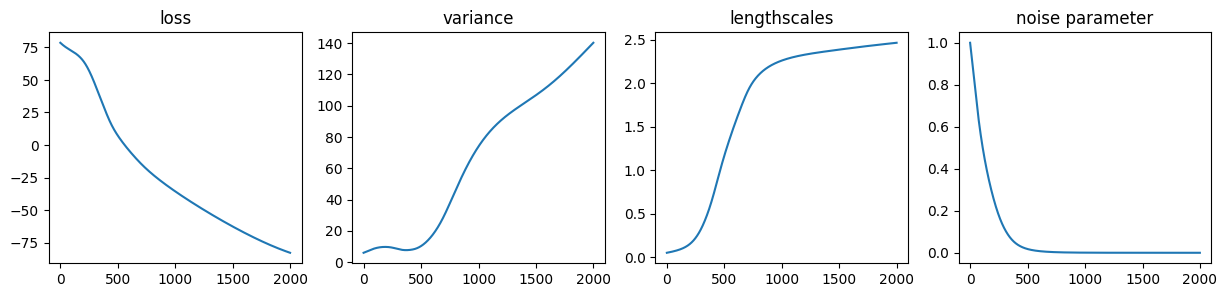

In [219]:
visualise_training(gpr_res['losses'], gpr_res['variances'], gpr_res['lengthscales'], gpr_res['noises'])

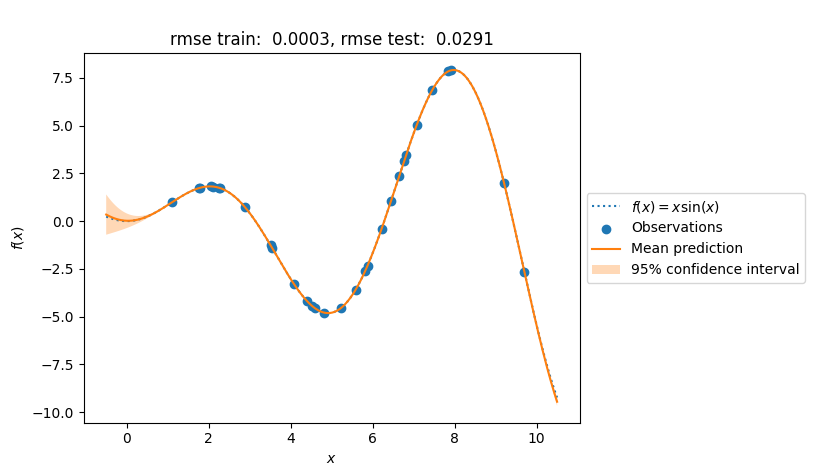

In [220]:
visualise_results(gpr)

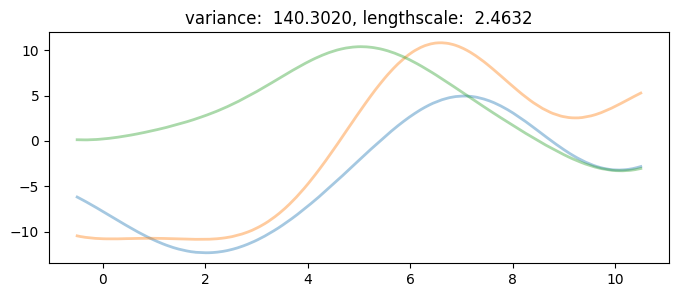

In [221]:
visualise_trajectories(gpr, fcn_key_, 3)

### Censored data

Applying "wrong modelling approach" to the censored data, i.e. neglecting the censoring.

In [222]:
kernel_censored = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr2 = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel_censored)
gpr2_res = optimise(gpr2)

100%|██████████| 2000/2000 [00:10<00:00, 195.39it/s]


variance =  11.318854
lengthscale =  1.221196
noise =  0.021373


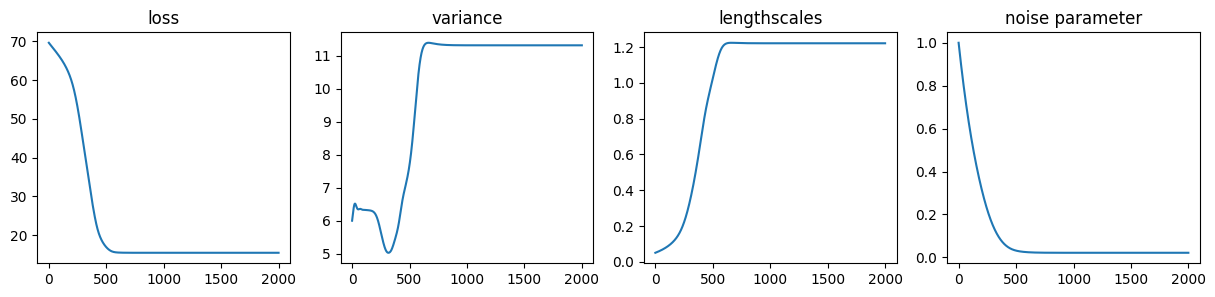

In [223]:
visualise_training(gpr2_res['losses'], gpr2_res['variances'], gpr2_res['lengthscales'], gpr2_res['noises'])

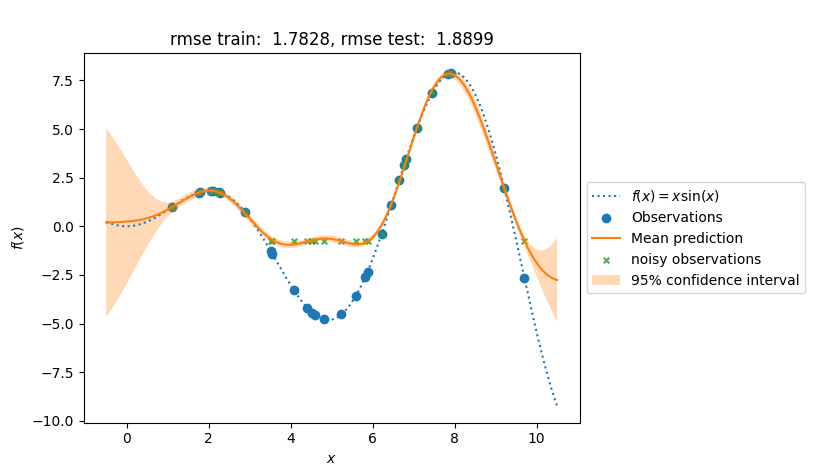

In [224]:
visualise_results(gpr2, censored=y_train_censored)

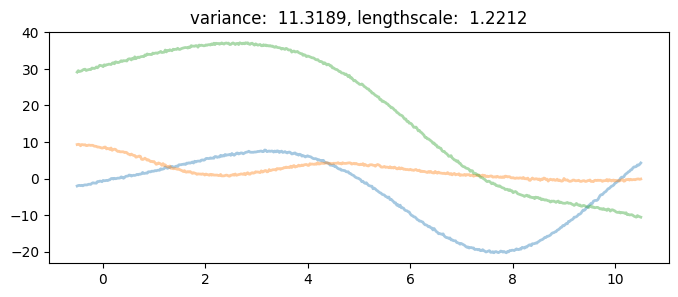

In [225]:
visualise_trajectories(gpr2, fcn_key_, 3)

### Censored + noise

Impact of the perturbations within the observed censored values.

In [226]:
kernel_censored_noise = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr3 = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train_noisy_censored), kernel_censored_noise)

gpr3_res = optimise(gpr3)

100%|██████████| 2000/2000 [00:09<00:00, 201.43it/s]


variance =  11.773749
lengthscale =  1.210111
noise =  0.021394


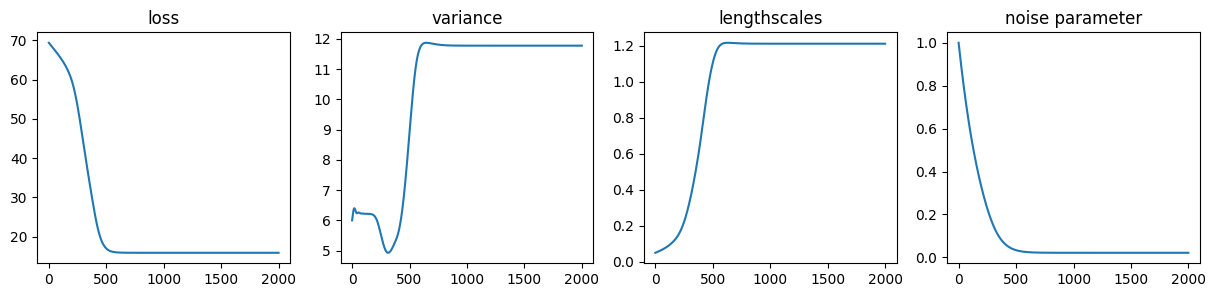

In [227]:
visualise_training(gpr3_res['losses'], gpr3_res['variances'], gpr3_res['lengthscales'], gpr3_res['noises'])

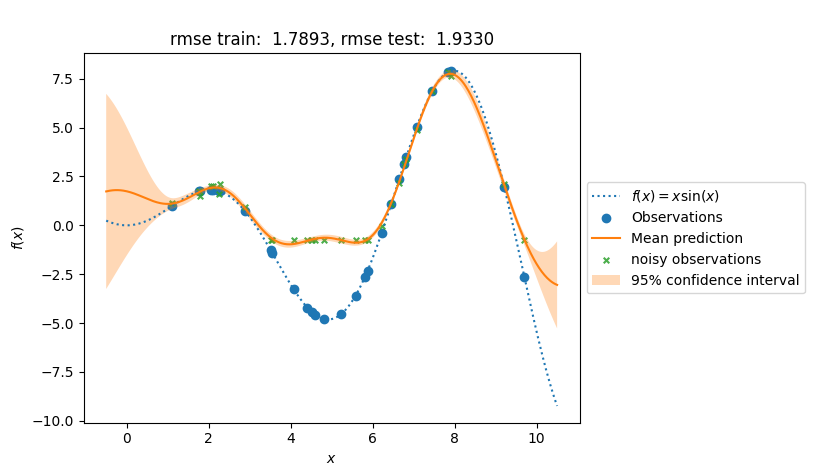

In [228]:
visualise_results(gpr3, censored=y_train_noisy_censored)

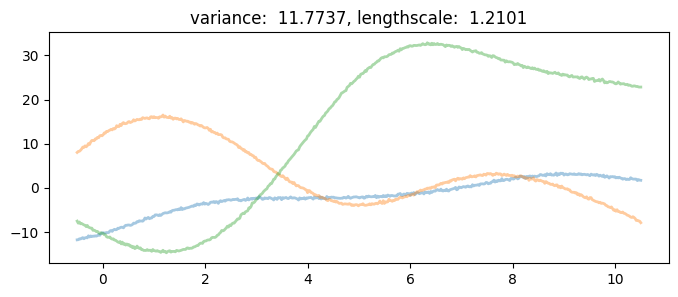

In [229]:
visualise_trajectories(gpr3, fcn_key_, 3)

## Custom Likelihood

This section uses object `VariationalGP` which supports usage of custom likelihoods.

 * We first check the performance for the Gaussian likelihood to understand the impact of choosing `VariationalGP` object instead of `GPRegressor`.
 * Then we apply explore using Censored Gaussian implementation.

In [230]:
import math
from numbers import Number, Real

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

from pyro.distributions.torch_distribution import TorchDistributionMixin

__all__ = ["CensoredNormal"]


class CensoredNormal(ExponentialFamily):
    r"""
    Creates a censored normal (also called Gaussian) distribution parameterized by
    :attr:`loc` and :attr:`scale` and :attr:`low`  and :attr:`high`

    Example::

        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> m = CensorNormal(
          torch.tensor([0.0]), torch.tensor([1.0]),
          torch.tensor([-0.5]), torch.tensor([0.5])
          )
        >>> m.sample(sample_shape=(3,1))
        tensor([[0.5000],
            [0.5000],
            [0.1836]])
        tensor([ 0.1046])

    Args:
        loc (float or Tensor): mean of the base normal distribution (often referred to as mu) to which the censoring is applied
        scale (float or Tensor): standard deviation of the base normal distribution to which the censoring is applied
        low (float or Tensor): lower censoring boundary
        high (float or Tensor): upper censoring boundary
    """
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "low": constraints.dependent(is_discrete=False, event_dim=0),
        "high": constraints.dependent(is_discrete=False, event_dim=0)}
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
      # adjust the moments such that it fits the censored normal
        return self.loc

    @property
    def stddev(self):
        return self.scale

    @property
    def variance(self):
        return self.stddev.pow(2)

    def __init__(self, loc, scale, low, high, validate_args=None):
        self.loc, self.scale, self.low, self.high = broadcast_all(loc, scale, low, high)
        if isinstance(loc, Number) and isinstance(scale, Number) and isinstance(low, Number) and isinstance(high, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        support = constraints.interval(low, high)
        super().__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CensoredNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        new.lower = self.low.expand(batch_shape)
        new.high = self.high.expand(batch_shape)
        super(CensoredNormal, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    # @constraints.dependent_property(is_discrete=False, event_dim=0)
    # def support(self):
    #     return constraints.interval(self.low, self.high)


    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            samples = torch.normal(self.loc.expand(shape), self.scale.expand(shape))
            return samples.clamp(min=self.low, max=self.high)


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        rsamples =  self.loc + eps * self.scale
        return rsamples.clamp(min=self.low, max=self.high)


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        # compute the variance
        var = self.scale**2
        log_scale = (
            math.log(self.scale) if isinstance(self.scale, Real) else self.scale.log()
        )
        log_probs = (
            -((value - self.loc) ** 2) / (2 * var)
            - log_scale
            - math.log(math.sqrt(2 * math.pi))
         )

        lower_censored_idx = (value <= self.low)
        upper_censored_idx = (value >= self.high)
        lower_cdf_mass = math.log(self._normal_cdf(self.low) + 1e-6) if isinstance(self._normal_cdf(self.low) + 1e-16,
                                                                                                Number) else (self._normal_cdf(self.low) + 1e-6).log()
        upper_cdf_mass = math.log(1 - self._normal_cdf(self.high) + 1e-6) if isinstance(1 - self._normal_cdf(self.high) + 1e-16,
                                                                                                    Number) else (1 - self._normal_cdf(self.high) + 1e-6).log()

        lower_cdf_mass = math.log(self._normal_cdf(self.low) + 1e-6) if isinstance(self._normal_cdf(self.low) + 1e-16,
                                                                                                Number) else (self._normal_cdf(self.low) + 1e-6).log()
        upper_cdf_mass = math.log(1 - self._normal_cdf(self.high) + 1e-6) if isinstance(1 - self._normal_cdf(self.high) + 1e-16,
                                                                                                    Number) else (1 - self._normal_cdf(self.high) + 1e-6).log()
        log_probs = torch.where(value <= self.low, lower_cdf_mass, log_probs)
        log_probs = torch.where(value >= self.high, upper_cdf_mass, log_probs)
        return log_probs

    def _normal_cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return 0.5 * (
            1 + torch.erf((value - self.loc) * self.scale.reciprocal() / math.sqrt(2))
        )

    def _normal_icdf(self, value):
        return self.loc + self.scale * torch.erfinv(2 * value - 1) * math.sqrt(2)

    def _normal_entropy(self):
        return 0.5 + 0.5 * math.log(2 * math.pi) + torch.log(self.scale)

    @property
    def _normal_natural_params(self):
        return (self.loc / self.scale.pow(2), -0.5 * self.scale.pow(2).reciprocal())

    def _log_normalizer(self, x, y):
        return -0.25 * x.pow(2) / y + 0.5 * torch.log(-math.pi / y)


class PyroCensoredNormal(CensoredNormal, TorchDistributionMixin):
    def __init__(self, loc, scale, low, high, validate_args=None):
        self._unbroadcasted_loc = loc
        self._unbroadcasted_scale = scale
        self._unbroadcasted_low = low
        self._unbroadcasted_high = high
        super().__init__(loc, scale, low, high, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CensoredNormal, _instance)
        new = super().expand(batch_shape, _instance=new)
        new._unbroadcasted_loc = self._unbroadcasted_loc
        new._unbroadcasted_scale = self._unbroadcasted_scale
        new._unbroadcasted_low = self._unbroadcasted_low
        new._unbroadcasted_high = self._unbroadcasted_high
        return new

    # @constraints.dependent_property(is_discrete=False, event_dim=0)
    # def support(self):
    #     return constraints.interval(self._unbroadcasted_low, self._unbroadcasted_high)

In [249]:
from pyro.contrib.gp.likelihoods.likelihood import Likelihood
from pyro.nn.module import PyroParam, pyro_method

class Gaussian(Likelihood):
    def __init__(self, variance=None):
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)

    def forward(self, f_loc, f_var, y=None):
        y_dist = dist.Normal(f_loc + torch.randn(f_loc.dim(), device=f_loc.device)*f_var, self.variance.sqrt())
        self.y_dist = y_dist
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f_loc.dim()]).to_event(y.dim())
        return pyro.sample(self._pyro_get_fullname("y"), y_dist, obs=y)


class CensoredHomoscedGaussian(Likelihood):

    def __init__(self, variance=None, low=None, high=None):
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)
        self.low = low
        self.high = high

    def forward(self, f_loc, f_var, y=None):
        y_dist = PyroCensoredNormal(loc=f_loc + torch.randn(f_loc.dim(), device=f_loc.device)*f_var, scale=self.variance.sqrt(), low=self.low, high=self.high)
        self.y_dist = y_dist
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f_loc.dim()]).to_event(y.dim())
        return pyro.sample("y", y_dist, obs=y)


class CensoredHeteroscedGaussian(Likelihood):

    def __init__(self, variance=None, low=None, high=None):
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)
        self.low = low
        self.high = high
        self.softplus = torch.nn.Softplus()

    def forward(self, f_loc, f_var, g_loc, g_var, y=None):
        scale = g_loc + torch.randn(g_loc.size(), device=g_loc.device)*g_var
        y_dist = PyroCensoredNormal(loc=f_loc + torch.randn(f_loc.size(), device=f_loc.device)*f_var, scale=self.softplus(scale), low=self.low, high=self.high)
        self.y_dist = y_dist
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f_loc.dim()]).to_event(y.dim())
        return pyro.sample("y", y_dist, obs=y)


In [250]:
likelihood = gp.likelihoods.Gaussian()
likelihood2 = Gaussian()
likelihood3 = CensoredHomoscedGaussian(low=lower_cf, high=1000.)
likelihood4 = CensoredHeteroscedGaussian(low=lower_cf, high=1000.)

### Gaussian

In [233]:
# set parameters for RBF kernel
var_ = 6.
lengthscale_ = 0.05

In [234]:
kernel1 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp1 = VariationalGP(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel=kernel1, likelihood=likelihood, whiten=True, jitter=1e-06)

In [235]:
vgp1_res = optimise(vgp1, 4000)

100%|██████████| 4000/4000 [00:33<00:00, 118.74it/s]


variance =  5.328082
lengthscale =  0.856543
noise =  0.000001


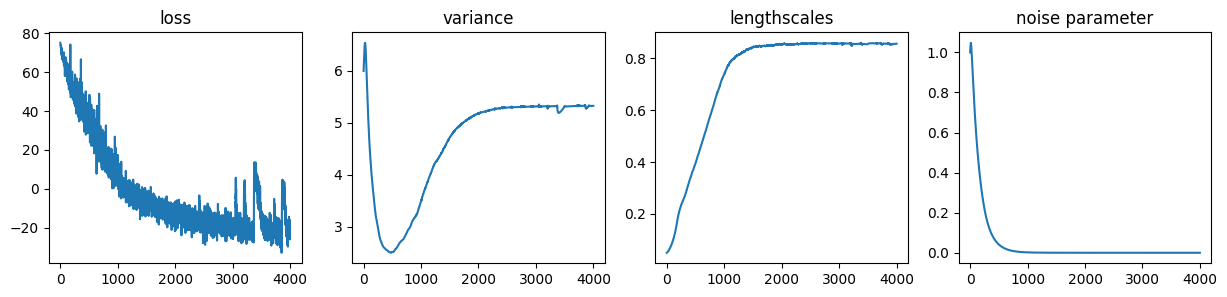

In [236]:
visualise_training(vgp1_res['losses'], vgp1_res['variances'], vgp1_res['lengthscales'], vgp1_res['noises'])

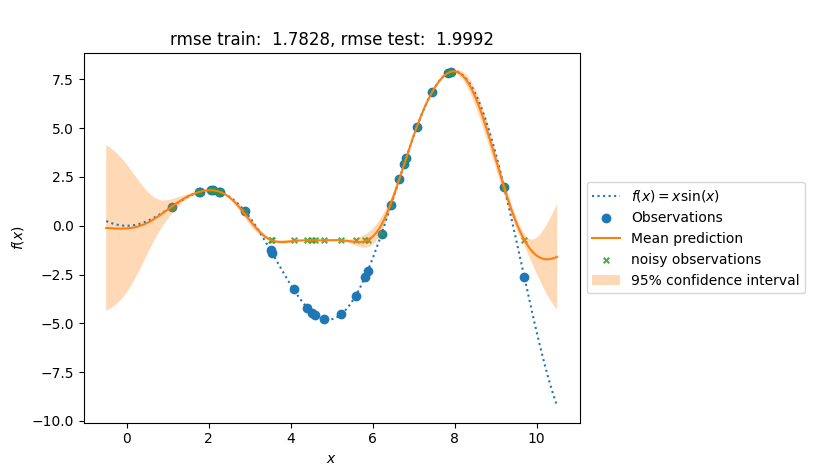

In [237]:
visualise_results(vgp1, censored=y_train_censored)

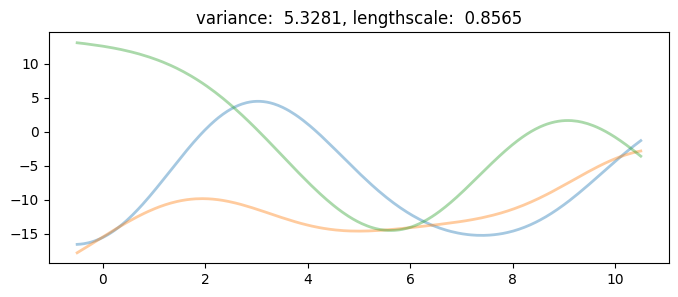

In [238]:
visualise_trajectories(vgp1, fcn_key_, 3)

### Censored Gaussian

* two different implementations of ELBO: `pyro.infer.TraceMeanField_ELBO()` and `pyro.infer.Trace_ELBO()`

In [239]:
kernel2 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp2 = VariationalGP(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel=kernel2, likelihood=likelihood3, whiten=True, jitter=1e-06)

In [240]:
vgp2_res = optimise(vgp2, num_steps=4000, MeanFieldElbo=True)

100%|██████████| 4000/4000 [00:42<00:00, 93.81it/s] 


variance =  6.897787
lengthscale =  1.123890
noise =  0.185321


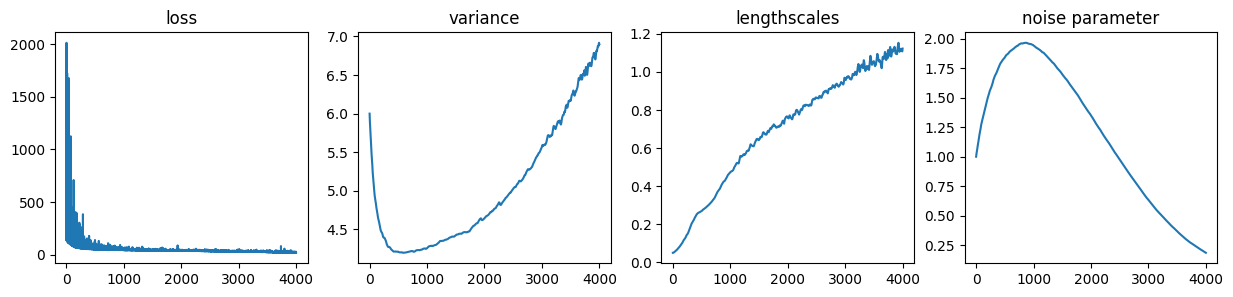

In [241]:
visualise_training(vgp2_res['losses'], vgp2_res['variances'], vgp2_res['lengthscales'], vgp2_res['noises'])

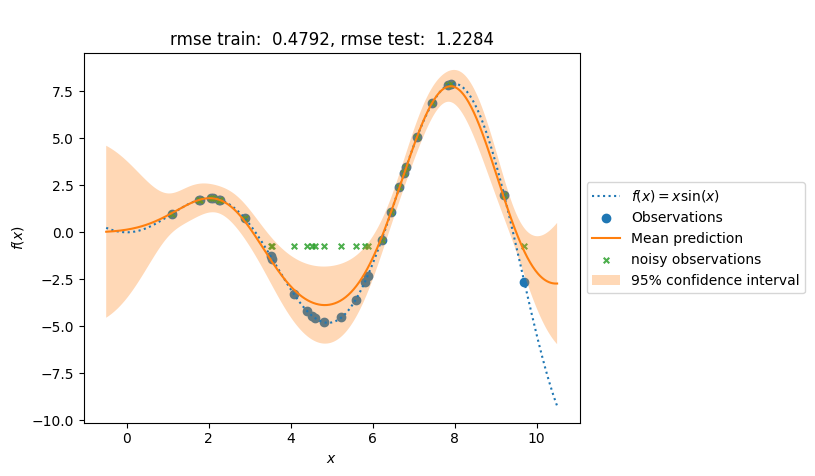

In [242]:
visualise_results(vgp2, censored=y_train_censored)

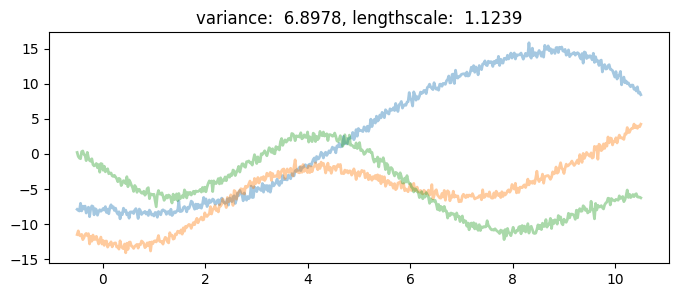

In [243]:
visualise_trajectories(vgp2, fcn_key_, 3)

In [244]:
kernel3 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp3 = VariationalGP(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel=kernel3, likelihood=likelihood3, whiten=True, jitter=1e-06)

In [245]:
vgp3_res = optimise(vgp3, num_steps=4000, MeanFieldElbo=False)

100%|██████████| 4000/4000 [00:40<00:00, 98.84it/s] 


variance =  4.589648
lengthscale =  0.745097
noise =  0.298636


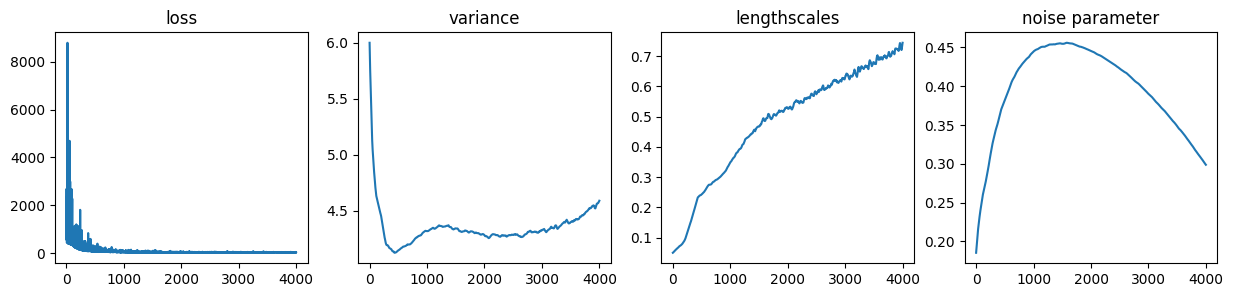

In [246]:
visualise_training(vgp3_res['losses'], vgp3_res['variances'], vgp3_res['lengthscales'], vgp3_res['noises'])

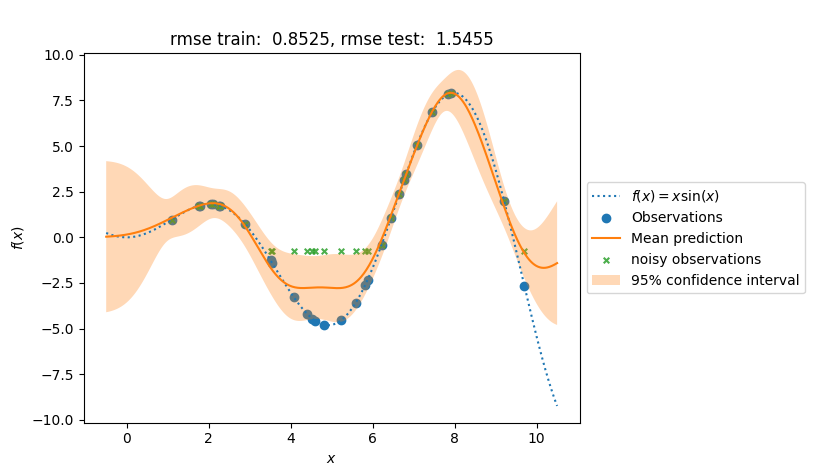

In [247]:
visualise_results(vgp3, censored=y_train_censored)

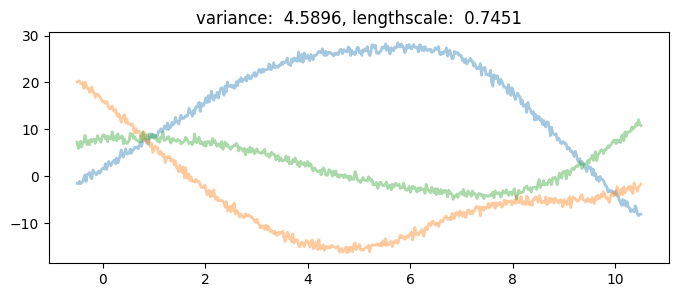

In [248]:
visualise_trajectories(vgp3, fcn_key_, 3)

### Censored Heterscedastic Gaussian Likelihood

In [253]:
kernel4 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp4 = VariationalGP(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel=kernel4, likelihood=likelihood4, whiten=True, jitter=1e-06)

In [254]:
# vgp4_res = optimise(vgp4, num_steps=4000, MeanFieldElbo=True)